# Main notebook for testing Mean-Reg-MTL

## 0. Load packages



In [1]:
import os
import sys
import copy
import torch
import scipy
import numpy as np
from numpy import matlib as mb
import matplotlib.pyplot as plt
sys.path.append(os.getcwd()+'/assistive_functions')

from household import Household, SyNet
from utils_households import get_lags, connect_to_households

## 1. Load households data

In [2]:
# number of devices and their group
num_households = 10
#group="ACORN-A"
stdorToU="ToU"
household_options = {"num_households":num_households,
#                    "group":group,
                    "stdorToU":stdorToU}

households = connect_to_households(household_options)


# regression options
options = {"dayparts":[],
           "resolution":60,
           "remove_holiday":True,
           "filt_days":['Tuesday'], 
           "replacement_method":'week_before',
           "feat_cols":['hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'temperature_hourly']}
step_ahead=1

# find dates when all households had data
date_st = []
date_en = []
for household in households:
    date_st.append(household.date_join)
    date_en.append(household.date_left)
date_st_com = max(date_st)
date_en_com = min(date_en)

# construct dataset
for household in households:
    household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options, 
                                date_st=date_st_com, date_en=date_en_com)
    household.train_test_split(test_frac=0.25)

[INFO] no filtering by group

[Warning]: data size mismatch
[Warning] data is too short (less than 1 year)
[Warning] less than 1 year of data
[INFO] households discarded

[Warning] less than 1 year of data
[INFO] households discarded


[INFO] Connected to 10 households


## 2. Mean-Regularized MTL Training

In [3]:
def print_param(model, message=''):
    with np.printoptions(precision=3, suppress=True):
        print(message+' model: \nbias = ' + 
              str(model.state_dict()['linear.bias'].numpy()[0]) +
              ', \nweights = ' + 
              str(model.state_dict()['linear.weight'].numpy().flatten()))
    return


def get_av_weights(households, **kwargs):
    models = kwargs.get('models', [household.model_mtl for household in households])
    in_dim = households[0].info['num_features']
    # find total samples
    tot_samp = 0
    for household in households:
        tot_samp = tot_samp + household.info['train_samples']
    # init
    bias = np.zeros(1)
    wght = np.zeros(in_dim)
    # aggregate    
    for model in models:
        # aggregate updates
        bias_hh = model.state_dict()['linear.bias'].numpy()
        wght_hh = model.state_dict()['linear.weight'].numpy().flatten()
        bias = bias_hh*household.info['train_samples']/tot_samp + bias
        wght = wght_hh*household.info['train_samples']/tot_samp + wght 
    return bias, wght

    
def mtl_train(households, lr, lambda_, inner_iters, outer_iters, optim_method, **kwargs):
    '''
    optim_method: Adam or SGD
    '''
    np.random.seed(30)
    torch.manual_seed(30)
    
    verbose = kwargs.get('verbose', False)
    # find total samples
    tot_samp = 0
    for household in households:
        tot_samp = tot_samp + household.info['train_samples']
    
    
    # initialize mtl for households
    init_state_dicts=[]
    for household in households:
        household.mtl_init(lr)
        init_state_dicts.append(copy.deepcopy(household.model_mtl.state_dict()))
    # initialize w_0
    in_dim=households[0].info['num_features']
    w_0 = SyNet(torch, in_dim=in_dim, out_dim=1)
    # find av initial weights
    init_bias, init_wght = get_av_weights(households)
    w_0.state_dict()['linear.weight'].copy_(torch.tensor(init_wght.reshape((1,len(init_wght)))))
    w_0.state_dict()['linear.bias'].copy_(torch.tensor(init_bias))
    
    # create optimizer
    if optim_method=='Adam':
        optim = torch.optim.Adam(params=w_0.parameters(), lr=lr)
    else:
        if optim_method=='SGD':
            optim = torch.optim.SGD(params=w_0.parameters(), momentum=0, lr=lr)
        else:
            print('Unsupported optimization method')
            return
    
    
    # iterate
    for i in np.arange(outer_iters):
        if verbose:
            print('\n before iter ' + str(i))
            print_param(w_0, 'w_0 ')
            
        # initialize param update
        cur_state_dict=copy.deepcopy(w_0.state_dict())
        w_0_wght = w_0.state_dict()['linear.weight']
        w_0_bias = w_0.state_dict()['linear.bias']
        delta_bias = np.zeros(1)
        delta_wght = np.zeros(in_dim)
        # run minibatch SGD for each household
        for household in households:
            # run minibatch SGD and get update in parameters
            db, dw = household.mtl_iterate(w_0_wght=w_0_wght, w_0_bias=w_0_bias,
                                           inner_iters=inner_iters, 
                                           lambda_=lambda_, verbose=False)
            # aggregate updates
            delta_bias = db*household.info['train_samples']/tot_samp + delta_bias
            delta_wght = dw*household.info['train_samples']/tot_samp + delta_wght
            # reset w_0
            for key, value in cur_state_dict.items():
                w_0.state_dict()[key].copy_(value)
        # update w_0
        new_bias = w_0_bias + torch.tensor(delta_bias.reshape((1)))
        new_wght = w_0_wght + torch.tensor(delta_wght.reshape((1,in_dim)))
        w_0.state_dict()['linear.weight'].copy_(new_wght)
        w_0.state_dict()['linear.bias'].copy_(new_bias)
        #print_param(w_0, 'Iteration ' + str(i) + ' ')

        #print(' ')
    # print trained parameters
    #print_param(w_0, 'Trained w_0 ')
    return w_0, init_state_dicts

## 3. Sanity Check
This section is for checking if the distributed MTL algorithm works correctly by experimenting with two extreme cases, when lambda=0 and lambda is very large. 

### 3.1 No regularization
First, we set lambda=0 to remove the regularization term. In this scenario, the MTL algorithm must return the same models as if each household fits a personal model on its' own local dataset. We run two tests: 1) apply MTL with lambda=0, 2) fit linear models to local datasets separately. If initiated at the same parameters, both methods return the same weights and bias. 

In [4]:
# METHOD 1: MTL
inner_iters = 10
outer_iters = 1
lr = 0.1
lambda_ = 0
w_0, init_state_dicts = mtl_train(households, lr=lr, lambda_=lambda_, 
          inner_iters=inner_iters, outer_iters=outer_iters, 
          optim_method='Adam', verbose=False)

# METHOD 2: separate local models
for h_ind, household in enumerate(households):
    household.fit_personal_model(method='Adam', lr=lr, 
                                 iterations = inner_iters*outer_iters, 
                                 init_state_dict=init_state_dicts[h_ind])

# Compare
tol = 5e-3
# compare mean model
matched = True
av_bias, av_wght = get_av_weights(households, models = [household.personal_lr for household in households]) 
w_0_bias = w_0.state_dict()['linear.bias'].numpy()
w_0_wght = w_0.state_dict()['linear.weight'].numpy().flatten()
dff_bias = np.abs(av_bias - w_0_bias)
dff_wght = np.abs(av_wght - w_0_wght)
if max(dff_bias)>tol:
    matched=False
    print('\nSanity check lambda=0 failed for w_0 due to bias mismatch.')
    print(w_0_bias)
    print(av_bias)
if max(dff_wght)>tol:
    matched=False
    print('\nSanity check lambda=0 failed for w_0 due to weight mismatch.')
    print(w_0_wght)
    print(av_wght)
    
# compare personal models
for h_ind, household in enumerate(households):
    plr_bias = household.personal_lr.state_dict()['linear.bias'].numpy()
    plr_wght = household.personal_lr.state_dict()['linear.weight'].numpy().flatten()
    mtl_bias = household.model_mtl.state_dict()['linear.bias'].numpy()
    mtl_wght = household.model_mtl.state_dict()['linear.weight'].numpy().flatten()
    dff_bias = np.abs(plr_bias - mtl_bias)
    dff_wght = np.abs(plr_wght - mtl_wght)
    if max(dff_bias) > tol:
        matched=False
        print('\nSanity check lambda=0 failed for household ' + str(h_ind) + ' due to bias mismatch.')
        print(plr_bias)
        print(mtl_bias)
    if max(dff_wght) > tol:
        matched=False
        print('\nSanity check lambda=0 failed for household ' + str(h_ind) + ' due to weight mismatch.')
        print(plr_wght)
        print(mtl_wght)
if matched:
    print('\nSanity check lambda=0 was successful.')


Sanity check lambda=0 was successful.


#### 3.2 Highly regularized

In [5]:
inner_iters = 20
outer_iters = 1
lr = 0.1
lambda_ = 100000
w_0, init_state_dict = mtl_train(households, lr=lr, lambda_=lambda_, 
          inner_iters=inner_iters, outer_iters=outer_iters, 
          optim_method='Adam', verbose=False)

# Compare
tol = 1e-1
w_0_bias = w_0.state_dict()['linear.bias'].numpy()
w_0_wght = w_0.state_dict()['linear.weight'].numpy().flatten()
for household in households:
    mtl_bias = household.model_mtl.state_dict()['linear.bias'].numpy()
    mtl_wght = household.model_mtl.state_dict()['linear.weight'].numpy().flatten()
    dff_bias = np.abs(w_0_bias - mtl_bias)
    dff_wght = np.abs(w_0_wght - mtl_wght)
    if np.all(dff_bias<tol) and np.all(dff_wght<tol):
        matched=True
    else:
        matched=False
        print('\nSanity check lambda=inf failed.')
        break
if matched:
    print('\nSanity check lambda=inf was successful.')


Sanity check lambda=inf was successful.


## 4. Benchmarking

In [6]:
lr = 0.1
inner_iters = 30
outer_iters = 30

In [7]:
def compute_av_consumption(households):
    # check length of data
    data_len_trn = households[0].info['train_samples']
    data_len_tst = households[0].info['test_samples']
    for household in households:
        if not household.info['train_samples']==data_len_trn:
            print('[Error] number of train samples of households was not equal')
            return
        if not household.info['test_samples']==data_len_tst:
            print('[Error] number of test samples of households was not equal')
            return
    
    # initialize average consumption
    y_av_trn = np.zeros((data_len_trn,1))
    y_av_tst = np.zeros((data_len_tst,1))
    # add up
    for household in households:
        y_av_trn += household.y_train
        y_av_tst += household.y_test
    # scale
    y_av_trn = y_av_trn/len(households)
    y_av_tst = y_av_tst/len(households)
    # flatten
    y_av_trn = y_av_trn.flatten()
    y_av_tst = y_av_tst.flatten()
    
    return y_av_trn, y_av_tst


# get real values
y_av_trn, y_av_tst = compute_av_consumption(households)

In [8]:
iterations = inner_iters*outer_iters
in_dim=households[0].info['num_features']
benchmark_models=[]

for household in households:
    model_bnc = SyNet(torch, in_dim=in_dim , out_dim=1)
    optim = torch.optim.Adam(params=model_bnc.parameters(),lr=lr)
    # iterate
    for i in range(iterations):
        optim.zero_grad()
        # predict
        output = model_bnc(torch.FloatTensor(household.X_train))
        # calculate loss
        loss = torch.nn.functional.mse_loss(output, torch.FloatTensor(y_av_trn.reshape(-1, 1)))
        loss.backward()
        optim.step()
    benchmark_models.append(model_bnc)

In [9]:
# initialize w_0
in_dim=households[0].info['num_features']
tsi = SyNet(torch, in_dim=in_dim, out_dim=1)
# find av personal weights
av_bias, av_wght = get_av_weights(households, models = [household.personal_lr for household in households]) 
tsi.state_dict()['linear.weight'].copy_(torch.tensor(av_wght.reshape((1,len(av_wght)))))
tsi.state_dict()['linear.bias'].copy_(torch.tensor(av_bias))

tensor([0.2928])

## 5. Performance Test

In [10]:
# params
log_lambdas = np.linspace(0,1.5,20)
lambdas = pow(10, log_lambdas)

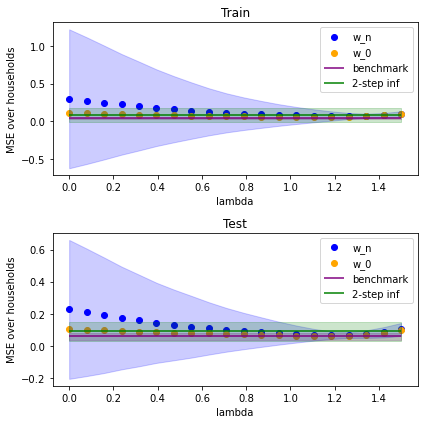

In [17]:
# two-stage inference
mse_tsi_trn = np.zeros(len(households))    # init
mse_tsi_tst = np.zeros(len(households))    # init
for h_ind, household in enumerate(households):
    # predict with two-step inference
    pred_tsi_trn = household.predict(household.X_train, method='Adam', model=tsi)
    pred_tsi_tst = household.predict(household.X_test,  method='Adam', model=tsi)
    # errors of tsi
    mse_tsi_trn[h_ind] = np.mean((pred_tsi_trn-y_av_trn)**2)
    mse_tsi_tst[h_ind] = np.mean((pred_tsi_tst-y_av_tst)**2)
# mean and std of errors
mse_tsi_trn_av = np.mean(mse_tsi_trn, axis=0)
mse_tsi_tst_av = np.mean(mse_tsi_tst, axis=0)
mse_tsi_trn_sd = np.var(mse_tsi_trn, axis=0)**0.5
mse_tsi_tst_sd = np.var(mse_tsi_tst, axis=0)**0.5


# benchmaak
mse_bnc_trn = np.zeros(len(households))
mse_bnc_tst = np.zeros(len(households))
# predict
for h_ind, household in enumerate(households): 
    # predict with benchmark
    pred_bnc_trn = household.predict(household.X_train, method='Adam', model=benchmark_models[h_ind])
    pred_bnc_tst = household.predict(household.X_test,  method='Adam', model=benchmark_models[h_ind])
    # errors of bnc
    mse_bnc_trn[h_ind] = np.mean((pred_bnc_trn-y_av_trn)**2)
    mse_bnc_tst[h_ind] = np.mean((pred_bnc_tst-y_av_tst)**2)
# mean and std of errors
mse_bnc_trn_av = np.mean(mse_bnc_trn, axis=0)
mse_bnc_tst_av = np.mean(mse_bnc_tst, axis=0)
mse_bnc_trn_sd = np.var(mse_bnc_trn, axis=0)**0.5
mse_bnc_tst_sd = np.var(mse_bnc_tst, axis=0)**0.5


# w_0 and w_n
mse_w_n_trn = np.zeros((len(households), len(lambdas)))
mse_w_n_tst = np.zeros((len(households), len(lambdas)))
mse_w_0_trn = np.zeros((len(households), len(lambdas)))
mse_w_0_tst = np.zeros((len(households), len(lambdas)))
# grid search lambda
for l_ind, lambda_ in enumerate(lambdas): 
    # train
    w_0, init_state_dict = mtl_train(households, lr=lr, lambda_=lambda_, 
              inner_iters=inner_iters, outer_iters=outer_iters, 
              optim_method='Adam', verbose=False)
    # predict
    for h_ind, household in enumerate(households): 
        # predict with w_n 
        pred_w_n_trn = household.predict(household.X_train, method='MTL')
        pred_w_n_tst = household.predict(household.X_test,  method='MTL')
        # predict with w_0
        pred_w_0_trn = household.predict(household.X_train, method='MTL', model=w_0)
        pred_w_0_tst = household.predict(household.X_test,  method='MTL', model=w_0)
        # errors of w_n
        mse_w_n_trn[h_ind, l_ind] = np.mean((pred_w_n_trn-y_av_trn)**2)
        mse_w_n_tst[h_ind, l_ind] = np.mean((pred_w_n_tst-y_av_tst)**2)
        # errors of w_0
        mse_w_0_trn[h_ind, l_ind] = np.mean((pred_w_0_trn-y_av_trn)**2)
        mse_w_0_tst[h_ind, l_ind] = np.mean((pred_w_0_tst-y_av_tst)**2) 
# mean and std of errors
mse_w_n_trn_av = np.mean(mse_w_n_trn, axis=0)
mse_w_n_tst_av = np.mean(mse_w_n_tst, axis=0)
mse_w_0_trn_av = np.mean(mse_w_0_trn, axis=0)
mse_w_0_tst_av = np.mean(mse_w_0_tst, axis=0)
mse_w_n_trn_sd = np.var(mse_w_n_trn, axis=0)**0.5
mse_w_n_tst_sd = np.var(mse_w_n_tst, axis=0)**0.5
mse_w_0_trn_sd = np.var(mse_w_0_trn, axis=0)**0.5
mse_w_0_tst_sd = np.var(mse_w_0_tst, axis=0)**0.5

# plot
xx = log_lambdas
fig,axs = plt.subplots(2,1,figsize=(6,6))
axs[0].scatter(xx, mse_w_n_trn_av, color='orange', label='w_n')
axs[0].scatter(xx, mse_w_0_trn_av, color='purple', label='w_0')
axs[0].hlines(mse_bnc_trn_av, xx[0], xx[-1], colors='blue', label='benchmark')
axs[0].hlines(mse_tsi_trn_av, xx[0], xx[-1], color='cyan',   label='2-step inf')
#axs[0].fill_between(xx, mse_w_n_trn_av-1.96*mse_w_n_trn_sd, mse_w_n_trn_av+1.96*mse_w_n_trn_sd, alpha=0.2, color='blue')
#axs[0].fill_between(xx, mse_bnc_trn_av-1.96*mse_bnc_trn_sd, mse_bnc_trn_av+1.96*mse_bnc_trn_sd, alpha=0.2, color='purple')
#axs[0].fill_between(xx, mse_tsi_trn_av-1.96*mse_tsi_trn_sd, mse_tsi_trn_av+1.96*mse_tsi_trn_sd, alpha=0.2, color='green')
axs[0].fill_between(xx, mse_w_0_trn_av-1.96*mse_w_0_trn_sd, mse_w_0_trn_av+1.96*mse_w_0_trn_sd,alpha=0.2, color='purple')
axs[0].set_title('Train')
axs[1].scatter(xx, mse_w_n_tst_av, color='orange', label='w_n')
axs[1].scatter(xx, mse_w_0_tst_av, color='purple', label='w_0')
axs[1].hlines(mse_bnc_tst_av, xx[0], xx[-1], colors='blue', label='benchmark')
axs[1].hlines(mse_tsi_tst_av, xx[0], xx[-1], color='cyan',   label='2-step inf')
#axs[1].fill_between(xx, mse_w_n_tst_av-1.96*mse_w_n_tst_sd, mse_w_n_tst_av+1.96*mse_w_n_tst_sd, alpha=0.2, color='blue')
#axs[1].fill_between(xx, mse_bnc_tst_av-1.96*mse_bnc_tst_sd, mse_bnc_tst_av+1.96*mse_bnc_tst_sd, alpha=0.2, color='purple')
#axs[1].fill_between(xx, mse_tsi_tst_av-1.96*mse_tsi_tst_sd, mse_tsi_tst_av+1.96*mse_tsi_tst_sd, alpha=0.2, color='green')
axs[1].fill_between(xx, mse_w_0_tst_av-1.96*mse_w_0_tst_sd, mse_w_0_tst_av+1.96*mse_w_0_tst_sd,alpha=0.2, color='purple')
axs[1].set_title('Test')
for ax in axs:
    ax.legend()
    ax.set_xlabel('log(lambda)')
    ax.set_ylabel('MSE over households')
plt.tight_layout()
plt.show()

plt.savefig('res.pdf', bbox_inches='tight')

In [33]:
print(min(mse_w_0_tst_av))
print(mse_bnc_tst_av)

print(min(mse_w_0_trn_av))
print(mse_bnc_trn_av)

0.06142524491374253
0.058840855654836856
0.05781544039885602
0.03849720840486427


In [34]:
# find if w_n was better for anyone
num = 0
for h_ind in np.arange(len(households)):
    min_wn = min(mse_w_n_tst[h_ind, :])
    min_w0 = min(mse_w_0_tst[h_ind, :])
    if min_w0>=min_wn:
        num +=1
print(num)

3
